# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import random 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.metrics import roc_curve,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# using SQLite Table to read data.

con = sqlite3.connect('drive/My Drive/FFRDB/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [0]:
final.sort_values('Time',inplace=True)
print(final.head(5))

          Id  ...                                               Text
70688  76882  ...  I bought a few of these after my apartment was...
1146    1245  ...  This was a really good idea and the final prod...
1145    1244  ...  I just received my shipment and could hardly w...
28086  30629  ...  Nothing against the product, but it does bothe...
28087  30630  ...  I love this stuff. It is sugar-free so it does...

[5 rows x 10 columns]


In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be ha

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be happily prov

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My dogs just love this food. The service is always fast and reliable.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My dogs just love this food The service is always fast and reliable 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:30<00:00, 2883.95it/s]


In [0]:
preprocessed_reviews[1500]

'dogs love food service always fast reliable'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.4.1] loading tfidf and w2v pickles

In [0]:
import pickle 
import os

dbfile1 = open('/content/drive/My Drive/FFRDB/tfidf.pkl', 'rb')  
tfidf_sent_vectors = pickle.load(dbfile1)  


dbfile2 = open('/content/drive/My Drive/FFRDB/sent_vectors.pkl', 'rb') 
sent_vectors= pickle.load(dbfile2)

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
#generating random alpha values between 10^-5 to 10^5
from numpy import random 
c=[]
#removing 0 as value from alpha
def remove_zero(a):
  while True:
    if 0 in a:
      a.pop(0)
      continue
    break
#removing dupliacte
def remove_dup(a):
  for i,j in enumerate(a):
    if i!=(len(a)-1):
      if j == a[i+1]:
        a.pop(i)

#generating alpha values one at a time
def generator(a):
  x,y=random.randint(-3,3),random.randint(0,9)
  z=round(y*10**x,abs(x))
  a.extend([z])
  return a.sort()

while len(c)!=40:
  generator(c)
  remove_dup(c)
  remove_zero(c)




# c=[1000,100,10,1,0.1,0.01,0.001,0.0001]
print(c)
print(len(c))

[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.01, 0.02, 0.04, 0.05, 0.06, 0.1, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 5, 6, 7, 8, 10, 20, 30, 50, 60, 70, 80, 100, 200, 300, 400, 500, 600, 700, 800]
40


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10,max_features=5000)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)


(61441, 5000)
(26332, 5000)


In [0]:
param = {'C':c}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
l1= LogisticRegression(penalty='l1', solver='liblinear')
temp_gscv= GridSearchCV(l1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.01, 0.02, 0.04, 0.05, 0.06, 0.1, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 5, 6, 7, 8, 10, 20, 30, 50, 60, 70, 80, 100, 200, 300, 400, 500, 600, 700, 800]}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.1min finished


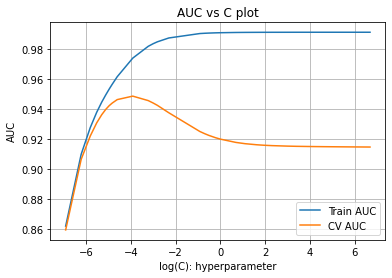

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(c),train_auc,label='Train AUC')
plt.plot(np.log(c),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.02530679255826418]
all local max C [0.02]
best cv score to use = 0.9488122858028978
best C to use = 0.02


In [0]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

lr = LogisticRegression(penalty='l1',C=best_c, solver='liblinear')
lr.fit(X_train,y_train)
y_pred_tr = lr.predict_proba(X_train)
y_pred_ts = lr.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]

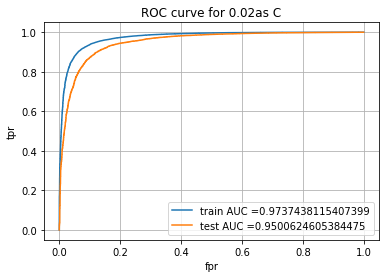

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.7896444699590777 for threshold 0.821
train
the maximum value of tpr*(1-fpr) 0.8482000151187687 for threshold 0.805


train Confusion Matrix


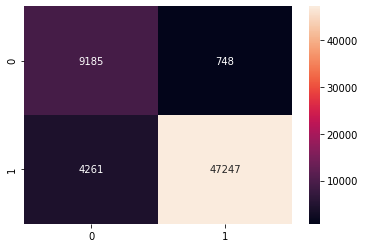

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


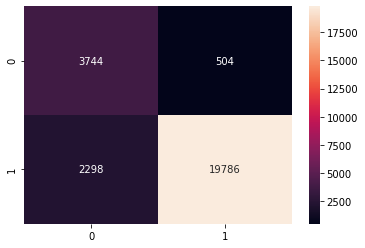

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 89.36%
Precision on test set: 97.52%
recall score on test set: 89.59%
f1 score on test set: 93.39%


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
non_zero_features=np.count_nonzero(lr.coef_)
print(f"Number of features with non-zero weights :{non_zero_features}")
print(f"Number of features with zero weights :{5000-non_zero_features}")

Number of features with non-zero weights :2361
Number of features with zero weights :2639


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
#generating random alpha values between 10^-5 to 10^5
from numpy import random 
c=[]
#removing 0 as value from alpha
def remove_zero(a):
  while True:
    if 0 in a:
      a.pop(0)
      continue
    break
#removing dupliacte
def remove_dup(a):
  for i,j in enumerate(a):
    if i!=(len(a)-1):
      if j == a[i+1]:
        a.pop(i)

#generating alpha values one at a time
def generator(a):
  x,y=random.randint(-3,3),random.randint(0,9)
  z=round(y*10**x,abs(x))
  a.extend([z])
  return a.sort()

while len(c)!=40:
  generator(c)
  remove_dup(c)
  remove_zero(c)




# c=[1000,100,10,1,0.1,0.01,0.001,0.0001]
print(c)
print(len(c))

[0.001, 0.002, 0.003, 0.004, 0.006, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 30, 50, 60, 80, 200, 400, 500, 600, 700, 800]
40


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)


(61441, 5000)
(26332, 5000)


In [0]:
param = {'C':c}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
l1= LogisticRegression(penalty='l2')
temp_gscv= GridSearchCV(l1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [0.001, 0.002, 0.003, 0.004, 0.006, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 30, 50, 60, 80, 200, 400, 500, 600, 700, 800]}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished


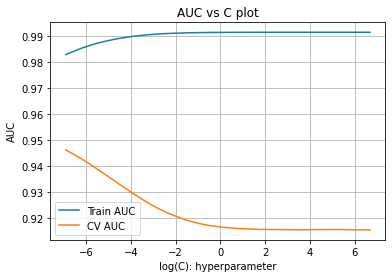

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(c),train_auc,label='Train AUC')
plt.plot(np.log(c),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.07553428709873644, 0.07560867286356143, 0.07563993861404084, 0.07561146158188525, 0.07570301744801444]
all local max C [7, 10, 60, 200, 600]
best cv score to use = 0.9157965703904208
best C to use = 7


In [0]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

lr = LogisticRegression(penalty='l2',C=best_c)
lr.fit(X_train,y_train)
y_pred_tr = lr.predict_proba(X_train)
y_pred_ts = lr.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]

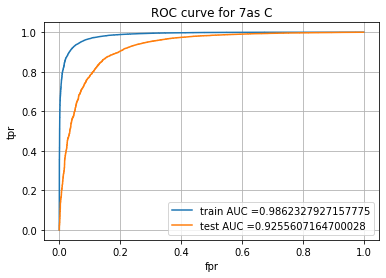

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.738226035005531 for threshold 0.926
train
the maximum value of tpr*(1-fpr) 0.8855549937161102 for threshold 0.818


train Confusion Matrix


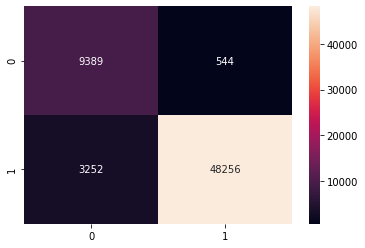

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


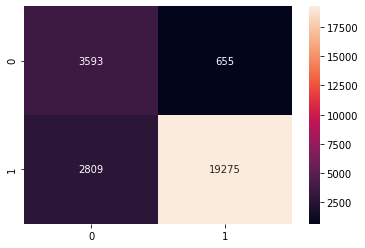

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 86.84%
Precision on test set: 96.71%
recall score on test set: 87.28%
f1 score on test set: 91.76%


In [0]:
count=0
value=[]
for i in lr.coef_.reshape(-1,1):
  count+=1
  value.extend(i)

x=vectorizer.get_feature_names()

log_features= pd.DataFrame({'feature_name':x,'value':value})

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation
epsilon = 0.00002
X_train.data = X_train.data +(epsilon,)
X_train.shape

(61441, 5000)

In [0]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

xlr = LogisticRegression(penalty='l2',C=best_c)
xlr.fit(X_train,y_train)
y_pred_tr = xlr.predict_proba(X_train)
y_pred_ts = xlr.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]

In [0]:
w1=lr.coef_+0.000001
w2=xlr.coef_+0.000001

In [0]:
p=abs((w1[0]-w2[0])/w1[0]*100)
p=list(i for i in p)

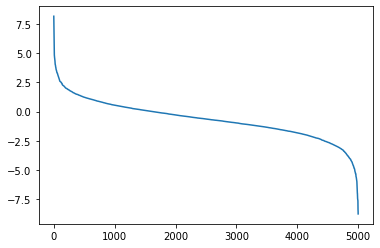

In [0]:
change=pd.DataFrame({'change_per':(p), 'feature':x}, index=range(count))
change.sort_values(by='change_per',ascending=False, inplace=True)
# change=change[change['change_per']>0]
plt.plot(range(change.shape[0]),np.log(change['change_per']))

In [0]:
'''
Algorithm to find elbow of a graph is taken from the following questionare on Stackoverflow
#######
https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
#######
'''
def elbow_finder(x_values):
  import numpy as np
  import numpy.matlib
  nPoints = len(x_values)
  allCoord = np.vstack((range(nPoints), x_values)).T
  np.array([range(nPoints), x_values])
  firstPoint = allCoord[0]
  lineVec = allCoord[-1] - allCoord[0]
  lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
  vecFromFirst = allCoord - firstPoint
  scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
  vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
  vecToLine = vecFromFirst - vecFromFirstParallel
  distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
  return np.argmax(distToLine)

In [0]:
x=elbow_finder(change['change_per'])
print(f'all the index before {x} is multicolinear as this is the elbow point')

all the index before 36 is multicolinear as this is the elbow point


In [0]:
change.iloc[:x]

,change_per,feature
3363,3467.691841,pour
3466,2274.404191,protein bars
4108,2180.684584,spring
4149,1253.551494,steak
1451,389.218805,favorite coffee
2445,216.970657,list ingredients
1313,213.763843,equivalent
1496,147.240872,final
3733,141.610713,royal
3577,127.106397,really love


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [0]:
log_features.sort_values(by = ['value'], ascending=False).head(10)

,feature_name,value
1872,great,1.022723
3797,say enough,0.901300
1072,delicious,0.818206
3698,right size,0.808981
1791,good,0.749260
3695,right amount,0.705956
325,best,0.654930
2054,highly recommend,0.624402
2834,no bitterness,0.582643
3249,perfect,0.573723


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
log_features.sort_values(by = ['value'], ascending=True).head(10)

,feature_name,value
2867,not,-0.969615
1145,disappointed,-0.449436
1240,earth best,-0.404937
4906,worst,-0.380955
1776,goat milk,-0.379761
3432,product,-0.368179
3003,not worth,-0.364820
4411,terrible,-0.353169
772,coco,-0.335525
243,bad,-0.330583


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
#generating random alpha values between 10^-5 to 10^5
from numpy import random 
c=[]
#removing 0 as value from alpha
def remove_zero(a):
  while True:
    if 0 in a:
      a.pop(0)
      continue
    break
#removing dupliacte
def remove_dup(a):
  for i,j in enumerate(a):
    if i!=(len(a)-1):
      if j == a[i+1]:
        a.pop(i)

#generating alpha values one at a time
def generator(a):
  x,y=random.randint(-3,3),random.randint(0,9)
  z=round(y*10**x,abs(x))
  a.extend([z])
  return a.sort()

while len(c)!=40:
  generator(c)
  remove_dup(c)
  remove_zero(c)




# c=[1000,100,10,1,0.1,0.01,0.001,0.0001]
print(c)
print(len(c))

[0.001, 0.003, 0.004, 0.007, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 10, 30, 50, 70, 80, 100, 200, 300, 400, 500, 600, 700, 800]
40


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(61441, 5000)
(26332, 5000)


In [0]:
param = {'C':c}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
l1= LogisticRegression(penalty='l1', solver='liblinear')
temp_gscv= GridSearchCV(l1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [0.001, 0.002, 0.003, 0.004, 0.005, 0.007, 0.008, 0.01, 0.02, 0.03, 0.05, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 6, 7, 8, 10, 20, 40, 50, 80, 100, 200, 300, 400, 500, 600, 700, 800]}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.1min finished


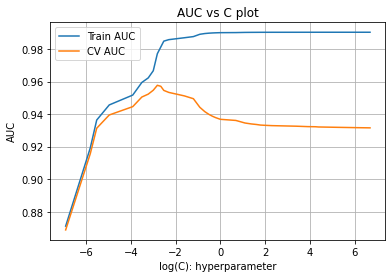

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(c),train_auc,label='Train AUC')
plt.plot(np.log(c),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.019429676063882795]
all local max C [0.06]
best cv score to use = 0.9577134597053177
best C to use = 0.06


In [0]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

lr = LogisticRegression(penalty='l1',C=best_c, solver='liblinear')
lr.fit(X_train,y_train)
y_pred_tr = lr.predict_proba(X_train)
y_pred_ts = lr.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]

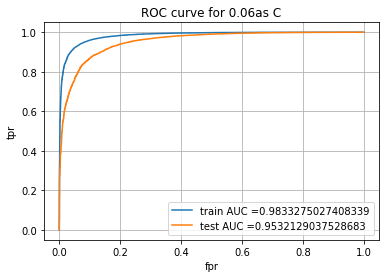

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.7838396244130014 for threshold 0.865
train
the maximum value of tpr*(1-fpr) 0.8759119333204912 for threshold 0.806


train Confusion Matrix


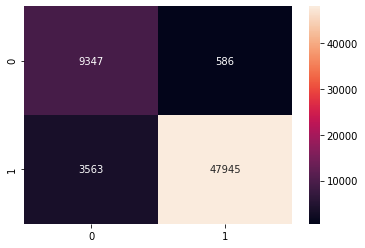

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


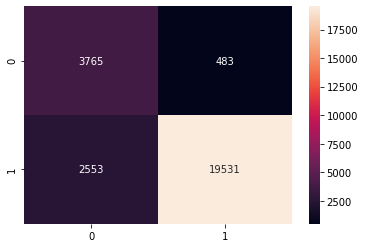

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 88.47%
Precision on test set: 97.59%
recall score on test set: 88.44%
f1 score on test set: 92.79%


In [0]:
non_zero_features=np.count_nonzero(lr.coef_)
print(f"Number of features with non-zero weights :{non_zero_features}")
print(f"Number of features with zero weights :{5000-non_zero_features}")

Number of features with non-zero weights :3854
Number of features with zero weights :1146


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
#generating random alpha values between 10^-5 to 10^5
from numpy import random 
c=[]
#removing 0 as value from alpha
def remove_zero(a):
  while True:
    if 0 in a:
      a.pop(0)
      continue
    break
#removing dupliacte
def remove_dup(a):
  for i,j in enumerate(a):
    if i!=(len(a)-1):
      if j == a[i+1]:
        a.pop(i)

#generating alpha values one at a time
def generator(a):
  x,y=random.randint(-3,3),random.randint(0,9)
  z=round(y*10**x,abs(x))
  a.extend([z])
  return a.sort()

while len(c)!=40:
  generator(c)
  remove_dup(c)
  remove_zero(c)




# c=[1000,100,10,1,0.1,0.01,0.001,0.0001]
print(c)
print(len(c))

[0.002, 0.004, 0.005, 0.006, 0.007, 0.008, 0.01, 0.02, 0.03, 0.04, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 2, 3, 4, 5, 6, 7, 10, 30, 40, 50, 60, 70, 80, 100, 200, 300, 400, 500, 600, 800]
40


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,random_state=0)

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train) 
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(61441, 5000)
(26332, 5000)


In [0]:
param = {'C':c}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
l1= LogisticRegression(penalty='l2')
temp_gscv= GridSearchCV(l1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [0.001, 0.003, 0.004, 0.005, 0.006, 0.007, 0.01, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 30, 50, 70, 100, 200, 300, 400, 500, 600, 800]}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished


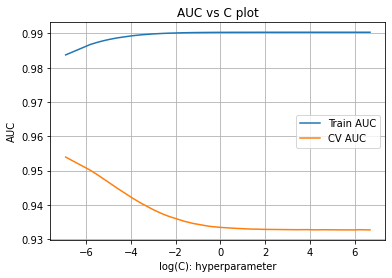

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(c),train_auc,label='Train AUC')
plt.plot(np.log(c),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.05755916536927985, 0.057588965404848924, 0.057576852450763716]
all local max C [50, 100, 500]
best cv score to use = 0.9327657288890322
best C to use = 50


In [0]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

lr = LogisticRegression(penalty='l2',C=best_c)
lr.fit(X_train,y_train)
y_pred_tr = lr.predict_proba(X_train)
y_pred_ts = lr.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]

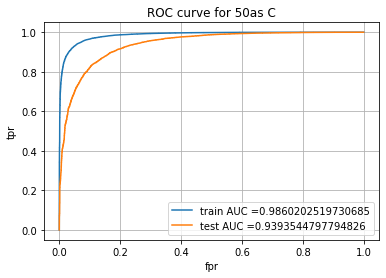

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.7480125959740773 for threshold 0.928
train
the maximum value of tpr*(1-fpr) 0.8858638796688609 for threshold 0.797


train Confusion Matrix


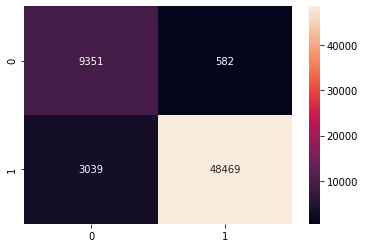

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


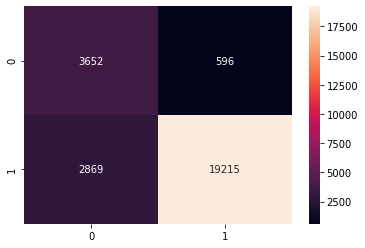

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 86.84%
Precision on test set: 96.99%
recall score on test set: 87.01%
f1 score on test set: 91.73%


In [0]:
count=0
value=[]
for i in lr.coef_.reshape(-1,1):
  count+=1
  value.extend(i)

x=vectorizer.get_feature_names()

log_features= pd.DataFrame({'feature_name':x,'value':value})

In [0]:
epsilon = 0.00002
X_train.data = X_train.data +(epsilon,)
X_train

<61441x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2079039 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

xlr = LogisticRegression(penalty='l2',C=best_c)
xlr.fit(X_train,y_train)
y_pred_tr = xlr.predict_proba(X_train)
y_pred_ts = xlr.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]

In [0]:
w1=lr.coef_+0.000001
w2=xlr.coef_+0.000001

In [0]:
p=abs((w1[0]-w2[0])/w1[0]*100)
p=list(i for i in p)

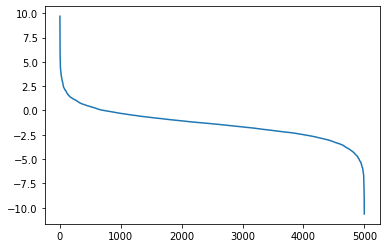

In [0]:
change=pd.DataFrame({'change_per':(p), 'feature':x}, index=range(count))
change.sort_values(by='change_per',ascending=False, inplace=True)
# change=change[change['change_per']>0]
plt.plot(range(change.shape[0]),np.log(change['change_per']))

In [0]:
'''
Algorithm to find elbow of a graph is taken from the following questionare on Stackoverflow
#######
https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
#######
'''
def elbow_finder(x_values):
  import numpy as np
  import numpy.matlib
  nPoints = len(x_values)
  allCoord = np.vstack((range(nPoints), x_values)).T
  np.array([range(nPoints), x_values])
  firstPoint = allCoord[0]
  lineVec = allCoord[-1] - allCoord[0]
  lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
  vecFromFirst = allCoord - firstPoint
  scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
  vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
  vecToLine = vecFromFirst - vecFromFirstParallel
  distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
  return np.argmax(distToLine)

In [0]:
x=elbow_finder(change['change_per'])
print(f'all the index before {x} is multicolinear as this is the elbow point')

all the index before 18 is multicolinear as this is the elbow point


In [0]:
change.iloc[:x]

,change_per,feature
342,16267.537796,better deal
2710,1878.043663,mix not
1577,574.235603,flavour
699,353.429829,chicken soup
3829,240.870293,section
1411,211.093968,fairly
3985,122.317819,smart
3926,115.609835,side effects
222,89.641187,auto ship
1303,76.031258,enough


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
log_features.sort_values(by = ['value'], ascending=False).head(10)

,feature_name,value
1872,great,1.043120
3797,say enough,1.020819
3698,right size,0.958855
1072,delicious,0.798143
1348,every penny,0.698103
3695,right amount,0.648381
2969,not regret,0.639794
325,best,0.592362
1791,good,0.590831
2833,no bitter,0.566061



#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
log_features.sort_values(by = ['value'], ascending=True).head(10)

,feature_name,value
2867,not,-0.564613
403,bob red,-0.403381
1145,disappointed,-0.392602
4906,worst,-0.346650
3003,not worth,-0.332548
3268,pg tips,-0.310997
4411,terrible,-0.285917
235,awful,-0.278173
374,bitter,-0.261726
4651,united states,-0.257312


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(sent_vectors,final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(61441, 50)
(26332, 50)


In [0]:
param = {'C':c}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
l1= LogisticRegression(penalty='l1', solver='liblinear')
temp_gscv= GridSearchCV(l1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [0.001, 0.002, 0.003, 0.004, 0.005, 0.007, 0.008, 0.01, 0.02, 0.03, 0.05, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 6, 7, 8, 10, 20, 40, 50, 80, 100, 200, 300, 400, 500, 600, 700, 800]}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.3min finished


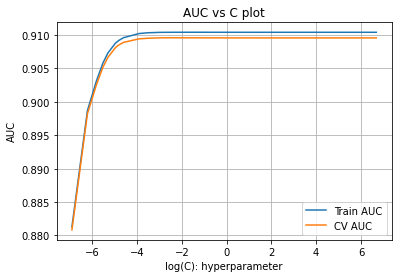

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(c),train_auc,label='Train AUC')
plt.plot(np.log(c),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.000821613809953492, 0.0008362096679768172, 0.0008423100624019852, 0.0008422906014544651, 0.0008433967481119575, 0.0008431618556553611, 0.0008425029079874857, 0.0008398848453644581]
all local max C [0.08, 0.8, 3, 7, 40, 100, 300, 500]
best cv score to use = 0.9095973270895991
best C to use = 0.08


In [0]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

lr = LogisticRegression(penalty='l1',C=best_c, solver='liblinear')
lr.fit(X_train,y_train)
y_pred_tr = lr.predict_proba(X_train)
y_pred_ts = lr.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]

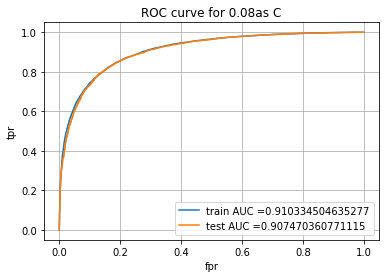

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6901199081166209 for threshold 0.803
train
the maximum value of tpr*(1-fpr) 0.6903026623801541 for threshold 0.829


train Confusion Matrix


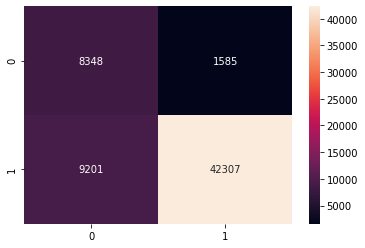

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


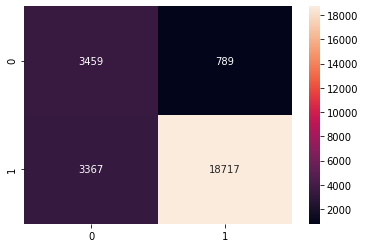

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 84.22%
Precision on test set: 95.96%
recall score on test set: 84.75%
f1 score on test set: 90.01%


In [0]:
non_zero_features=np.count_nonzero(lr.coef_)
print(f"Number of features with non-zero weights :{non_zero_features}")
print(f"Number of features with zero weights :{5000-non_zero_features}")

Number of features with non-zero weights :48
Number of features with zero weights :4952


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [0]:
#generating random alpha values between 10^-5 to 10^5
from numpy import random 
c=[]
#removing 0 as value from alpha
def remove_zero(a):
  while True:
    if 0 in a:
      a.pop(0)
      continue
    break
#removing dupliacte
def remove_dup(a):
  for i,j in enumerate(a):
    if i!=(len(a)-1):
      if j == a[i+1]:
        a.pop(i)

#generating alpha values one at a time
def generator(a):
  x,y=random.randint(-3,3),random.randint(0,9)
  z=round(y*10**x,abs(x))
  a.extend([z])
  return a.sort()

while len(c)!=40:
  generator(c)
  remove_dup(c)
  remove_zero(c)


# c=[1000,100,10,1,0.1,0.01,0.001,0.0001]
print(c)
print(len(c))

[0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008, 0.03, 0.04, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 8, 20, 30, 40, 50, 60, 70, 80, 100, 200, 300, 400, 500, 600, 700, 800]
40


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(sent_vectors,final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(61441, 50)
(26332, 50)


In [0]:
param = {'C':c}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
l1= LogisticRegression(penalty='l2')
temp_gscv= GridSearchCV(l1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008, 0.03, 0.04, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 8, 20, 30, 40, 50, 60, 70, 80, 100, 200, 300, 400, 500, 600, 700, 800]}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.4min finished


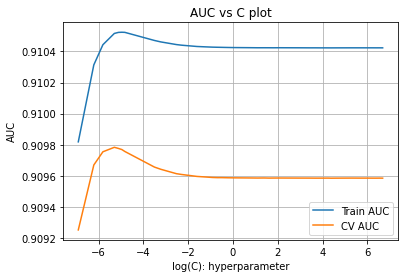

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(c),train_auc,label='Train AUC')
plt.plot(np.log(c),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.0007325497170500572, 0.0008382568072425878, 0.0008378678855427424, 0.0008381982973316715, 0.000837914340929391, 0.0008380669820008402, 0.0008382166943246006, 0.0008382258839230161]
all local max C [0.005, 0.6, 4, 8, 70, 200, 400, 700]
best cv score to use = 0.90978336245962
best C to use = 0.005


In [0]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

lr = LogisticRegression(penalty='l2',C=best_c)
lr.fit(X_train,y_train)
y_pred_tr = lr.predict_proba(X_train)
y_pred_ts = lr.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]

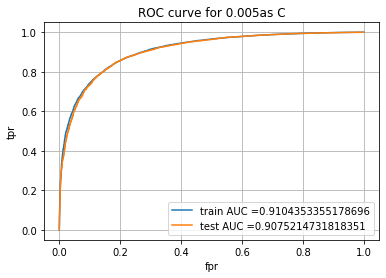

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6904011702791363 for threshold 0.804
train
the maximum value of tpr*(1-fpr) 0.6902407972352401 for threshold 0.821


train Confusion Matrix


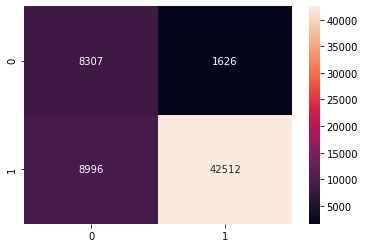

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


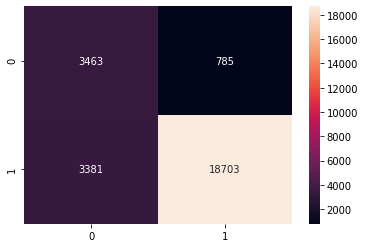

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 84.18%
Precision on test set: 95.97%
recall score on test set: 84.69%
f1 score on test set: 89.98%


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors,final['Score'].values,test_size=0.3,random_state=0)

ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(61441, 50)
(26332, 50)


In [0]:
param = {'C':c}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
l1= LogisticRegression(penalty='l2')
temp_gscv= GridSearchCV(l1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.008, 0.02, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3, 0.4, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 20, 30, 40, 50, 60, 70, 80, 100, 200, 300, 400, 500, 600, 700, 800]}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.4min finished


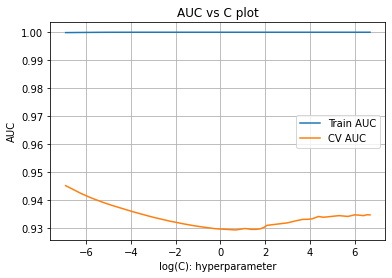

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(c),train_auc,label='Train AUC')
plt.plot(np.log(c),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.0701128003159106, 0.06581496103410067, 0.0655186103251224, 0.06523652497376142, 0.06518577171984141]
all local max C [3, 80, 200, 400, 700]
best cv score to use = 0.9348121320323994
best C to use = 700


In [0]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

lr = LogisticRegression(penalty='l2',C=best_c)
lr.fit(X_train,y_train)
y_pred_tr = lr.predict_proba(X_train)
y_pred_ts = lr.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]

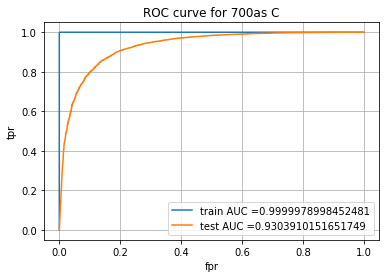

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.7364320906547198 for threshold 1.0
train
the maximum value of tpr*(1-fpr) 0.9983310581298521 for threshold 0.889


train Confusion Matrix


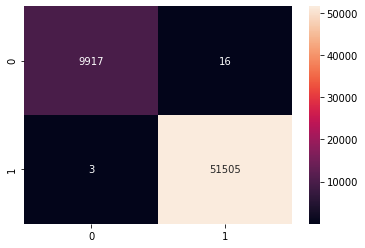

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


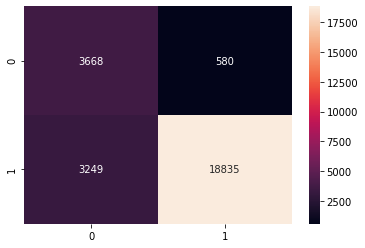

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 85.46%
Precision on test set: 97.01%
recall score on test set: 85.29%
f1 score on test set: 90.77%


### [5.4.2] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors,final['Score'].values,test_size=0.3,random_state=0)


ss = StandardScaler(with_mean = False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(61441, 50)
(26332, 50)


In [0]:
param = {'C':c}
print(param)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
l1= LogisticRegression(penalty='l1', solver='liblinear')
temp_gscv= GridSearchCV(l1,param,cv=5,verbose=5,n_jobs=-1,scoring='roc_auc',return_train_score=True)
temp_gscv.fit(X_train,y_train)
temp_gs = pd.DataFrame.from_dict(temp_gscv.cv_results_)

{'C': [0.001, 0.003, 0.004, 0.007, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 10, 30, 50, 70, 80, 100, 200, 300, 400, 500, 600, 700, 800]}
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.7min finished


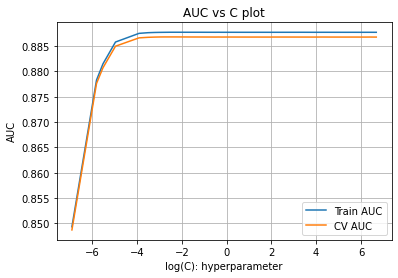

In [0]:
train_auc= temp_gs['mean_train_score']
cv_auc= temp_gs['mean_test_score']
plt.plot(np.log(c),train_auc,label='Train AUC')
plt.plot(np.log(c),cv_auc ,label='CV AUC')

# plt.scatter(param['n_neighbors'],train_auc,label='Train AUC')
# plt.scatter(param['n_neighbors'], cv_auc, label='cv AUC')
plt.grid()
plt.title('AUC vs C plot')
plt.xlabel("log(C): hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()
plt.clf()
plt.cla()
plt.close()

In [0]:
#finding the best CV score first then using the one which is least distant then its AUC counter part to avoid using Dumb model.

from scipy.signal import argrelextrema
import numpy as np
x = np.array(train_auc)
y = np.array(cv_auc)
local_max=()
#finding local maximas of CV
local_max_i=argrelextrema(y, np.greater)
l=list(i for i in np.nditer(local_max_i))


diff=x-y
# diff between CV and Test AUC at the local maxima
local_diff=list(diff[i] for i in l)
local_c=list(c[i] for i in l)
print(f'all local differences {local_diff}')
print(f'all local max C {local_c}')

for i in np.nditer(np.argmin(local_diff)):
  v=i
  break
print(f'best cv score to use = {y[l[v]]}')
best_c=c[l[v]]
print(f'best C to use = {c[l[v]]}')

all local differences [0.0009249588816485632, 0.0009374255448282298, 0.0009368188325815652, 0.0009394946224473566, 0.0009434546224182938, 0.0009365700408060507, 0.0009350217442005704, 0.000941195484980617, 0.0009371853388489004]
all local max C [0.1, 0.7, 1, 4, 6, 8, 70, 300, 600]
best cv score to use = 0.8868188831531668
best C to use = 0.1


In [0]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_curve, auc

lr = LogisticRegression(penalty='l1',C=best_c, solver='liblinear')
lr.fit(X_train,y_train)
y_pred_tr = lr.predict_proba(X_train)
y_pred_ts = lr.predict_proba(X_test)
y_pred_ts=y_pred_ts[:,1]
y_pred_tr = y_pred_tr[:,1]

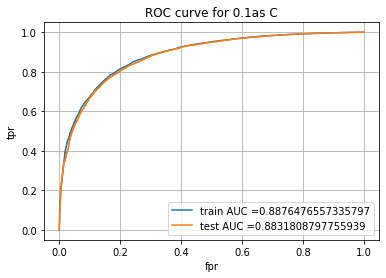

In [0]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_tr)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_ts)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (best_c)+'as C')
plt.legend()
plt.grid()
plt.show()

In [0]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

print('train')
best_tr_thres = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

test
the maximum value of tpr*(1-fpr) 0.6438650205123325 for threshold 0.821
train
the maximum value of tpr*(1-fpr) 0.652366733483056 for threshold 0.823


train Confusion Matrix


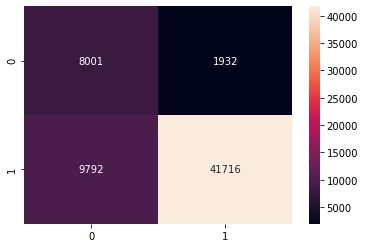

In [0]:
print('train Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_pred_tr, best_tr_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

Test Confusion Matrix


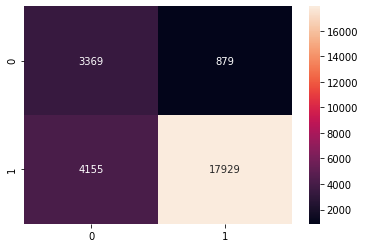

In [0]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_pred_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [0]:
acc=accuracy_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
ps=precision_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
rc=recall_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100
f1=f1_score(y_test, predict_with_best_t(y_pred_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 80.88%
Precision on test set: 95.33%
recall score on test set: 81.19%
f1 score on test set: 87.69%


In [0]:
non_zero_features=np.count_nonzero(lr.coef_)
print(f"Number of features with non-zero weights :{non_zero_features}")

Number of features with non-zero weights :49


# [6] Conclusions

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.NO.", "MODEL",  "C value", "Penalty","Test AUC","Precision Score"]
x.add_row(["1", "BOW", "0.02", "L1","0.9500","97.52%"])
x.add_row(["", "BOW", "7", "L2","0.9255","96.71%"])
x.add_row(["2", "TFIDF","0.02", "L1","0.9583","97.85%"])
x.add_row(["", "TFIDF", "50", "L2","0.9393","96.99%"])
x.add_row(["3", "AVG W2V", "0.08", "L1","0.9074","95.96%"])
x.add_row(["", "AVG W2V", "0.05", "L2","0.9075","95.97%"])
x.add_row(["4", "TFIDF W2V", "0.001", "L1","0.8831","95.33%"])
x.add_row(["", "TFIDF W2V","700", "L2","0.9303","97.01%"])
print(x)

+-------+-----------+---------+---------+----------+-----------------+
| S.NO. |   MODEL   | C value | Penalty | Test AUC | Precision Score |
+-------+-----------+---------+---------+----------+-----------------+
|   1   |    BOW    |   0.02  |    L1   |  0.9500  |      97.52%     |
|       |    BOW    |    7    |    L2   |  0.9255  |      96.71%     |
|   2   |   TFIDF   |   0.02  |    L1   |  0.9583  |      97.85%     |
|       |   TFIDF   |    50   |    L2   |  0.9393  |      96.99%     |
|   3   |  AVG W2V  |   0.08  |    L1   |  0.9074  |      95.96%     |
|       |  AVG W2V  |   0.05  |    L2   |  0.9075  |      95.97%     |
|   4   | TFIDF W2V |  0.001  |    L1   |  0.8831  |      95.33%     |
|       | TFIDF W2V |   700   |    L2   |  0.9303  |      97.01%     |
+-------+-----------+---------+---------+----------+-----------------+


In [0]:
!sudo apt-get install pandoc texlive-xetex
!jupyter nbconvert --to pdf AFFR_Log_Reg.ipynb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
[NbConvertApp] Converting notebook AFFR_Log_Reg.ipynb to pdf
[NbConvertApp] Support files will be in AFFR_Log_Reg_files/
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertApp] Making directory ./AFFR_Log_Reg_files
[NbConvertA